# Model Explanation

## Imports & Functions

In [ ]:
pip install transformers

In [ ]:
pip install transformers_interpret

In [ ]:
pip install shap

In [ ]:
import pandas as pd
import numpy as np
import pickle
import operator
from operator import itemgetter
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from transformers import logging
logging.set_verbosity_error()
import matplotlib.image
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from itertools import islice
import json
import csv
import statistics
import collections
from nltk.tokenize import TweetTokenizer
import re
import os
os.nice(10)
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers_interpret import SequenceClassificationExplainer
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import torch
from sklearn.metrics import f1_score
import pickle
from collections import Counter
from transformers import logging
logging.set_verbosity_error()
import json
import csv
import warnings
warnings.filterwarnings("ignore")
from csv import writer
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers_interpret import SequenceClassificationExplainer
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import torch
from sklearn.metrics import f1_score
import pickle
from collections import Counter
from transformers import logging
logging.set_verbosity_error()
import json
import csv
import os
os.nice(10)
import transformers
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)
import shap

In [ ]:
def predictor(texts):
  outputs = model(**tokenizer(texts, return_tensors="pt", padding=True,  truncation=True, max_length=512))
  probas = F.softmax(outputs.logits).detach().numpy()
  return probas

def get_word_attributions_class(model, tokenizer, data):
    cls_explainer = SequenceClassificationExplainer(model,tokenizer)
    texts = data.text.to_list()
    real_class = data.target.to_list()
    mapping = {'NON_HATE':0, 'HATE':1} 
    corrected_pred = 0
    class_explained = []
    for i in range(len(texts)): 
        text = texts[i]
        word_attributions = cls_explainer(text)
        class_explained.append(word_attributions)
        if real_class[i] == mapping[cls_explainer.predicted_class_name]:
            corrected_pred +=1
    PIK = "IG_class_expl.dat"
    with open('/content/gdrive/My Drive/Colab Notebooks/XAI/'+PIK, "wb") as f:
      pickle.dump(class_explained, f)
    return class_explained

def vocabClass(lime_v,preds,X_test):
  vocabularyNonAbusive={}
  vocabularyAbusive={}
  corrected_pred = 0
  real_class = X_test.target
  for i in range(len(X_test)): #for record
    if real_class[i] == 0:
      abusive=False
    else:
      abusive=True
    if preds[i] >= 0.5:
      pred=1 
      for elem in lime_v[i]: #for word
        if '##' not in elem[0] and '[CLS]' not in elem[0] and '[SEP]' not in elem[0]:
          if elem[0] not in vocabularyAbusive:
            vocabularyAbusive[elem[0]]=[]
          vocabularyAbusive[elem[0]].append(elem[1]) #append expl. w.r.t. predicted class
    else:
      pred=0 
      for elem in lime_v[i]: #for word
        if '##' not in elem[0] and '[CLS]' not in elem[0] and '[SEP]' not in elem[0]:
          if elem[0] not in vocabularyNonAbusive:
            vocabularyNonAbusive[elem[0]]=[]
          vocabularyNonAbusive[elem[0]].append(elem[1]) #append expl. w.r.t. predicted class
    if real_class[i] == pred:
      corrected_pred +=1
  print('Accuracy', corrected_pred/len(X_test))
  return vocabularyNonAbusive, vocabularyAbusive

def buildResult(vocabulary):
  temp=[]
  for k, v in vocabulary.items():
    if len(v)>1:
      vocabulary[k]=np.asarray(v).mean()
    temp.append(len(v))
  res=pd.DataFrame.from_dict(vocabulary)
  res = res.T 
  res.columns = ['FI']
  res['Freq'] = temp
  res = res.sort_values(by='FI', ascending=False)
  return res 

In [ ]:
def plot_wc(class_word_attention):
  fig = plt.figure(figsize=(20,12))
  for i,key in enumerate(class_word_attention):
    ax = fig.add_subplot(3,3,i+1)
    ax.set_title(key, fontsize=26)
    wordcloud = WordCloud(background_color='white', width = 1000, height=600, margin=2).fit_words(class_word_attention[key])
    ax.imshow(wordcloud)
    ax.axis('off')
  fig.tight_layout(w_pad=2)
  fig.show()

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def plot_barchart(class_word_attention,n):
    n_col, n_row = 2,1
    fig, axs = plt.subplots(n_row,n_col, figsize=(12, 6))
    for i,key in enumerate(class_word_attention):
        row = i // n_col
        col = i % n_col 
        n_words = take(n, class_word_attention[key].items()) # take top n words
        x, y = zip(*n_words) # unpack a list of pairs into two tuples
        axs[col].bar(x, y, color='royalblue', alpha=0.7)
        axs[col].grid(color='#95a5a6', linestyle='--', linewidth=0.5, axis='y', alpha=0.7)
        axs[col].tick_params(axis='x', rotation=65, labelsize=10)
        axs[col].set_xlabel('Word', fontsize=20)
        axs[col].set_ylabel('Avg Word Attribution', fontsize=20)
        axs[col].set_title(key, size=26)
    fig.tight_layout(w_pad=2)
    fig.show()

def plot_higher_attributed_words(explanations):
    higher_words_value = dict()
    for word_att in explanations:
        first_word = list(explanations[word_att].keys())[0]
        higher_words_value[first_word] = explanations[word_att][first_word]
    higher_words_value = {k: v for k, v in sorted(higher_words_value.items(), key=lambda item: item[1], reverse=True)}
    higher_words = list(higher_words_value.keys())
    higher_values = list(higher_words_value.values())
    plt.rcParams["figure.figsize"] = (5,2)
    plt.bar(higher_words, higher_values, align='center', color='royalblue', alpha=0.7)
    plt.xticks(higher_words, rotation=90) # replace default x-ticks with xs, then replace xs with labels
    plt.show()
    return higher_words

def analyze_explanations(X_test,preds,expl_file,n):
    vocabularyNonAbusive, vocabularyAbusive = vocabClass(expl_file,preds,X_test)
    FI_NonAbusive = buildResult(vocabularyNonAbusive)
    FI_Abusive = buildResult(vocabularyAbusive)

    scaler = MinMaxScaler()
    FI_NonAbusive['FI'] = scaler.fit_transform(FI_NonAbusive[['FI']])
    scaler = MinMaxScaler()
    FI_Abusive['FI'] = scaler.fit_transform(FI_Abusive[['FI']])

    FI_NA_D = FI_NonAbusive.to_dict()
    FI_NA_D = FI_NA_D['FI']
    FI_A_D = FI_Abusive.to_dict()
    FI_A_D = FI_A_D['FI']
    d={'NonAbusive':FI_NA_D,'Abusive':FI_A_D}
    
    plot_barchart(d,n)
    plot_wc(d)

    return d 

In [ ]:
def topImportance(d):
  max_keys_Abusive = sorted(d['Abusive'], key=d['Abusive'].get, reverse=True)[:3]
  print('Top importance in Abusive: ',max_keys_Abusive)
  max_keys_NonAbusive = sorted(d['NonAbusive'], key=d['NonAbusive'].get, reverse=True)[:3]
  print('Top importance in Non Abusive: ', max_keys_NonAbusive)
  return max_keys_Abusive,max_keys_NonAbusive

def computeAccuracy(X_test,preds):
  corrected_preds = 0
  for i in range(len(X_test)): #for record
    if preds[i] >= 0.5:
      pred=1
    else:
      pred=0
    if X_test['target'][i] == pred:
      corrected_preds +=1
  accuracy=corrected_preds/len(X_test)
  print('Accuracy: ', accuracy)
  return accuracy

def perturb(X_test,preds,max_key): 
  init_accuracy = computeAccuracy(X_test,preds)
  n_removed=0
  preds_new=[]
  sentencesOrig=[]
  sentencesPerturb=[]
  X_test_perturbed=X_test.copy()
  for i in range(len(X_test)): #for record
    found=False
    for key in max_key:
      if re.search(r"\b"+key+"(\b|\W)", X_test['text'][i]):
        found=True
        X_test_perturbed['text'][i] = re.sub(r"\b"+key+"(\b|\W)", '', X_test_perturbed['text'][i])         
    if found:
      n_removed+=1
      sentencesOrig.append(X_test['text'][i])
      sentencesPerturb.append(X_test_perturbed['text'][i])
      preds_new.append(predictor([X_test_perturbed['text'][i]])[0, 1])
    else:
      preds_new.append(preds[i])
  print('N° of records containing the top-3 important words: ',n_removed)
  accuracy = computeAccuracy(X_test,preds_new)
  print('Difference:', abs(init_accuracy - accuracy))
  return sentencesOrig,sentencesPerturb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

## 1. Explain w IntGrad

In [ ]:
# model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                          num_labels=2,
                                                          output_attentions=False,
                                                          output_hidden_states=False)
model_path = '/content/gdrive/My Drive/Colab Notebooks/XKDD/finetuned_BERT_epoch_1.model' 
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 

df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/XKDD/test.csv')

X_test=df

texts = df.text.to_list()

PIK = "IG_class_expl.dat"
with open('/content/gdrive/My Drive/Colab Notebooks/XKDD/'+PIK, "rb") as f:
  IG_v = pickle.load(f)

'''preds=[]
for i in range(len(X_test)):
  preds.append(predictor([df['text'][i]])[0, 1])
print(len(preds))
PIK = "preds.dat"
with open('/content/gdrive/My Drive/Colab Notebooks/XKDD/'+PIK, "wb") as f:
  pickle.dump(preds, f)'''

PIK = "preds.dat"
with open('/content/gdrive/My Drive/Colab Notebooks/XKDD/'+PIK, "rb") as f:
  preds = pickle.load(f)

#### Global

Accuracy 0.9412528178154246


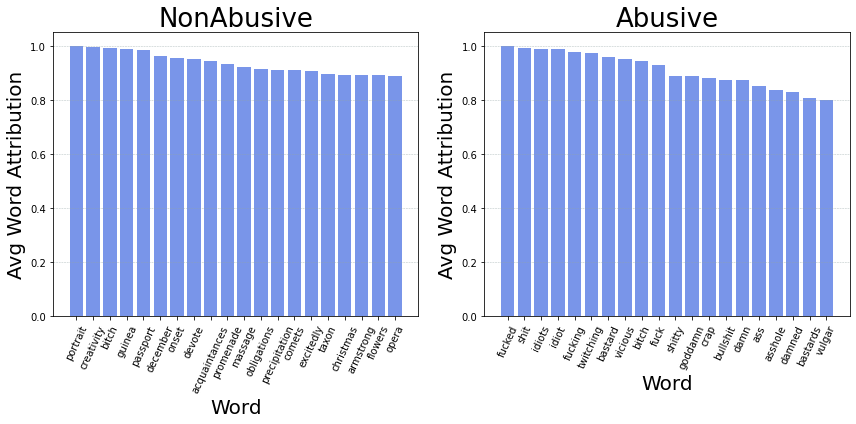

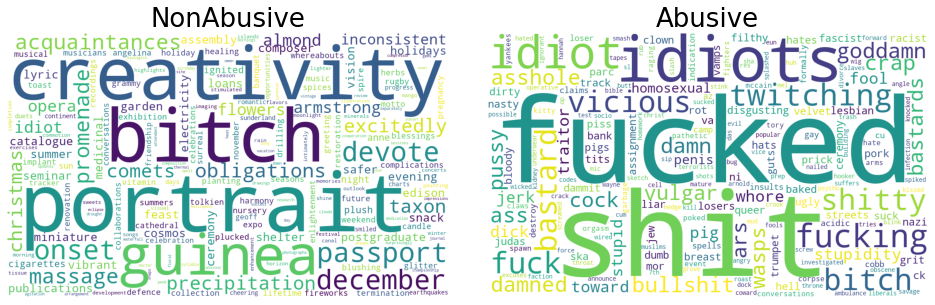

In [ ]:
d=analyze_explanations(X_test,preds,IG_v,20)

In [ ]:
max_keys_Abusive,max_keys_NonAbusive=topImportance(d)

Top importance in Abusive:  ['fucked', 'shit', 'idiots']
Top importance in Non Abusive:  ['portrait', 'creativity', 'bitch']


In [ ]:
sortedNA = sorted(d['NonAbusive'].items(), key=operator.itemgetter(1), reverse=True)
sortedNA

[('portrait', 1.0),
 ('creativity', 0.9942742058871501),
 ('bitch', 0.9937147525757596),
 ('guinea', 0.98714693767171),
 ('passport', 0.9846316622335967),
 ('december', 0.9627052452341194),
 ('onset', 0.957027913178266),
 ('devote', 0.9500409626130036),
 ('acquaintances', 0.9455256486390418),
 ('promenade', 0.9348945068430015),
 ('massage', 0.9214938989747605),
 ('obligations', 0.9160108776942557),
 ('precipitation', 0.9093064405151574),
 ('comets', 0.9092125375433324),
 ('excitedly', 0.9078066338774939),
 ('taxon', 0.8967702119717321),
 ('christmas', 0.89329174554858),
 ('armstrong', 0.8919248723988249),
 ('flowers', 0.8915503753379923),
 ('opera', 0.8892204258498155),
 ('almond', 0.886798014482889),
 ('idiot', 0.8844762949000556),
 ('inconsistent', 0.8837968836133225),
 ('postgraduate', 0.882899144461781),
 ('safer', 0.8828116077321562),
 ('feast', 0.8789986877983074),
 ('assembly', 0.8740963379748432),
 ('holidays', 0.8723118135687247),
 ('catalogue', 0.8720255485788964),
 ('vibrant

In [ ]:
sortedA = sorted(d['Abusive'].items(), key=operator.itemgetter(1), reverse=True)
sortedA

[('fucked', 0.9999999999999999),
 ('shit', 0.9922960969923457),
 ('idiots', 0.9894826222866009),
 ('idiot', 0.987566806743749),
 ('fucking', 0.9775684612514876),
 ('twitching', 0.9740237814254169),
 ('bastard', 0.9592861452128941),
 ('vicious', 0.951643999936299),
 ('bitch', 0.9452371607267253),
 ('fuck', 0.9312099125627898),
 ('shitty', 0.889605494797971),
 ('goddamn', 0.8885156930610894),
 ('crap', 0.8830109850991417),
 ('bullshit', 0.8756276141675164),
 ('damn', 0.8738298861022078),
 ('ass', 0.8531114565000542),
 ('asshole', 0.8358208084082274),
 ('damned', 0.8312357527199536),
 ('bastards', 0.8066008835350015),
 ('vulgar', 0.7993108872310715),
 ('cock', 0.791354039133874),
 ('ars', 0.7897647792462208),
 ('pussy', 0.7814817681379271),
 ('wasps', 0.7802308805799099),
 ('stupidity', 0.7791141112103133),
 ('traitor', 0.7762740199108685),
 ('stupid', 0.7735403191758077),
 ('toward', 0.7641383262719945),
 ('whore', 0.7598906351509485),
 ('dick', 0.75387055366154),
 ('fool', 0.74503600696

#### Subset 

In [ ]:
! git clone https://github.com/MartaMarchiori/twitteraae
from twitteraae.code import *
%cd twitteraae/code
import predict
predict.load_model()

Cloning into 'twitteraae'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 72 (delta 6), reused 0 (delta 0), pack-reused 43
Unpacking objects: 100% (72/72), done.
/content/twitteraae/code


Output proportions are for the African-American, Hispanic, Asian, and White topics, respectively: inference of the proportion of words in the text that come from a demographically-associated language/dialect. As we state in the paper, we only consider the AA and White categories to be reliable and useful, and conducted linguistic validation only for those two categories.

As recommended,
we assign dialect labels to tweets with dialect
probabilities greater than 80%

Relaxing constraint 

In [ ]:
predict.predict(u"Wussup niggas".split())[0]

0.8691316887977836

In [ ]:
predict.predict(u"Y'all hos".split())[0]

0.7679170513789355

In [ ]:
ids = []
for i in range(len(texts)):
  v=predict.predict(texts[i].split())
  if v is not None:
    if v[0] >= 0.7:
          ids.append(i)

In [ ]:
print(len(ids))
print(ids)
for i in ids:
  print(texts[i])

74
[170, 431, 1087, 1353, 1418, 1464, 1573, 1833, 1842, 1863, 2038, 3089, 3118, 3162, 3234, 3268, 3277, 3315, 3616, 3956, 3996, 4546, 4606, 4654, 5264, 5330, 5358, 5390, 5423, 5483, 5673, 5751, 5886, 5896, 6114, 6406, 6439, 6677, 7228, 7326, 7664, 8608, 8760, 9222, 9318, 9481, 9542, 9970, 10074, 10096, 10546, 10716, 10813, 10910, 11079, 11188, 11224, 11505, 11518, 11556, 11766, 12039, 12502, 12740, 12781, 13055, 13072, 13305, 13827, 13914, 14008, 14120, 14152, 14594]
2day I cry.Me n God don sign am,I knw say u dey see the post no let my enemies laugh me. Pls 4giv my sins n enrich my bag
@USER: These lil bitches dirty af &#128557;&#128175; #LHHATL
Bitches be too mad bitch get some money and move out the hood you fake ballers&#127948;&#127998;‍♀️&#129335;&#127998;‍♀️
This why bitches like u get beat up nasty ass URL
@USER: Ay tighten up yo ppl jumped me &#128514;&#128514;&#128514; fuck wrong wit yo stupid ass nun my dawgs touched u so stop that flaaaggggginnnn…
@USER: Everybody ain't gon

#### Subglobal

In [ ]:
AAE_X_test=X_test.loc[ids]
AAE_X_test=AAE_X_test.reset_index()
AAE_X_test = AAE_X_test.drop(['index'],True)
AAE_X_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,text,target
0,"2day I cry.Me n God don sign am,I knw say u de...",0
1,@USER: These lil bitches dirty af &#128557;&#1...,1
2,Bitches be too mad bitch get some money and mo...,1
3,This why bitches like u get beat up nasty ass URL,1
4,@USER: Ay tighten up yo ppl jumped me &#128514...,1
...,...,...
69,@USER: I need y'all support with this one: we ...,1
70,YAW GOT MY BABYDADDY @USER FUCKED UP&#129315;&...,1
71,@USER: Im sick asl this nigga Tee Grizzley at ...,1
72,@USER: All these niggas want what I got so Ima...,1


In [ ]:
AAE_X_test.target.value_counts()

1    65
0     9
Name: target, dtype: int64

In [ ]:
AAE_preds = list(itemgetter(*ids)(preds))
AAE_preds

[0.0036629776,
 0.9991103,
 0.9990972,
 0.99912184,
 0.99910295,
 0.99908507,
 0.99675304,
 0.999089,
 0.99907035,
 0.9991165,
 0.9990491,
 0.999119,
 0.99911207,
 0.0005680946,
 0.9991221,
 0.99910814,
 0.9990988,
 0.9991196,
 0.999116,
 0.99910814,
 0.99910516,
 0.9991097,
 0.9991135,
 0.9990576,
 0.9991209,
 0.9990977,
 0.02650353,
 0.999094,
 0.00057295983,
 0.99912184,
 0.99909496,
 0.9990982,
 0.07603434,
 0.9988433,
 0.9990815,
 0.9990491,
 0.99912006,
 0.9991203,
 0.99910176,
 0.99911374,
 0.67436844,
 0.00057121384,
 0.999119,
 0.9991091,
 0.99900156,
 0.9990922,
 0.9990858,
 0.99911314,
 0.99910504,
 0.99911493,
 0.9991235,
 0.99909246,
 0.99911207,
 0.99910754,
 0.9990909,
 0.99911016,
 0.99911267,
 0.00057006243,
 0.9991221,
 0.99910897,
 0.9990121,
 0.99911135,
 0.99909544,
 0.9991165,
 0.9991014,
 0.9991235,
 0.9990994,
 0.9991204,
 0.99910897,
 0.999022,
 0.99909604,
 0.9990963,
 0.9990483,
 0.9991191]

In [ ]:
AAE_IG_v = list(itemgetter(*ids)(IG_v))
AAE_IG_v

[[('[CLS]', 0.0),
  ('2d', 0.12563791799128415),
  ('##ay', 0.02312768603522396),
  ('i', 0.09786263819606687),
  ('cry', 0.18431161768315912),
  ('.', 0.09829553398610097),
  ('me', 0.12057784742391194),
  ('n', -0.20595402783284172),
  ('god', -0.06436315080627043),
  ('don', 0.035570880417735415),
  ('sign', 0.01594144361719148),
  ('am', -0.1406577359394026),
  (',', 0.07763029290749568),
  ('i', -0.11944539270390767),
  ('kn', -0.03443843255693949),
  ('##w', -0.07380434284383441),
  ('say', -0.07812880274801806),
  ('u', -0.1814081820404875),
  ('de', -0.011523407885005485),
  ('##y', 0.03876744908180276),
  ('see', -0.07590796217986681),
  ('the', -0.05837487584939853),
  ('post', 0.14493249673254646),
  ('no', 0.015168928719644434),
  ('let', -0.004276077422870215),
  ('my', -0.09932152215437645),
  ('enemies', -0.5179323912401186),
  ('laugh', 0.24055346674374276),
  ('me', -0.08200914200019903),
  ('.', 0.04255484653510435),
  ('pl', 0.09573260460493248),
  ('##s', 0.04983585

Accuracy 0.9459459459459459


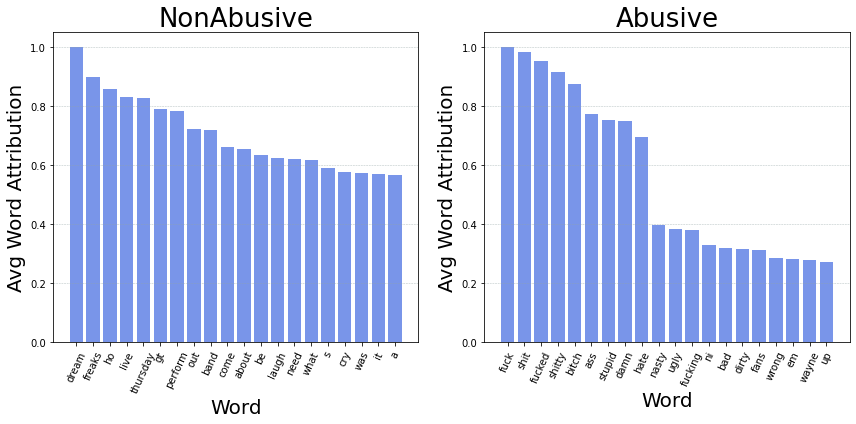

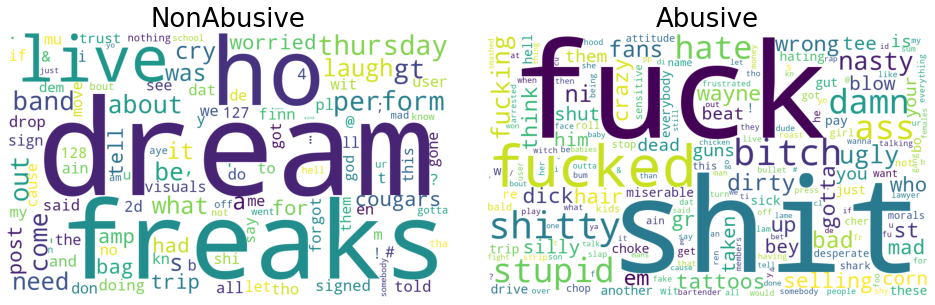

In [ ]:
d=analyze_explanations(AAE_X_test,AAE_preds,AAE_IG_v,20)

In [ ]:
max_keys_Abusive,max_keys_NonAbusive=topImportance(d)

Top importance in Abusive:  ['fuck', 'shit', 'fucked']
Top importance in Non Abusive:  ['dream', 'freaks', 'ho']


In [ ]:
sortedNA = sorted(d['NonAbusive'].items(), key=operator.itemgetter(1), reverse=True)
sortedNA

[('dream', 1.0),
 ('freaks', 0.8976830668582989),
 ('ho', 0.8575176425582486),
 ('live', 0.8301102821776409),
 ('thursday', 0.8261559543175168),
 ('gt', 0.7900083705145408),
 ('perform', 0.7848322143778484),
 ('out', 0.7242286353286385),
 ('band', 0.7209349685470152),
 ('come', 0.6626481001561683),
 ('about', 0.6550847484574434),
 ('be', 0.63543078060812),
 ('laugh', 0.6230817074948498),
 ('need', 0.6202414546857887),
 ('what', 0.6181063523778376),
 ('s', 0.590445854683715),
 ('cry', 0.5768800980957176),
 ('was', 0.5738315969260972),
 ('it', 0.5716770343988505),
 ('a', 0.5674028153179766),
 ('cougars', 0.5672874022935823),
 ('trip', 0.5629983869766805),
 ('bag', 0.5627405262933296),
 (',', 0.5577623787076832),
 ('for', 0.5550374566502565),
 ('had', 0.5488443200539446),
 ('worried', 0.5464607181251798),
 ('tell', 0.5455382708479346),
 ('post', 0.5445308991445672),
 ('amp', 0.5359366822531793),
 ('doing', 0.5358079878062691),
 ('we', 0.5344647080098657),
 ('told', 0.5339211800654041),
 (

In [ ]:
sortedA = sorted(d['Abusive'].items(), key=operator.itemgetter(1), reverse=True)
sortedA

[('fuck', 1.0),
 ('shit', 0.9834203189450217),
 ('fucked', 0.9519466229471243),
 ('shitty', 0.9171454122151803),
 ('bitch', 0.8749890785518089),
 ('ass', 0.7737979220181086),
 ('stupid', 0.7542031003172254),
 ('damn', 0.748479885558117),
 ('hate', 0.6940873994752568),
 ('nasty', 0.39613270664177525),
 ('ugly', 0.385115663886817),
 ('fucking', 0.3812971682390058),
 ('ni', 0.32813863093521684),
 ('bad', 0.3183214192048792),
 ('dirty', 0.3158685019628166),
 ('fans', 0.31174251030515043),
 ('wrong', 0.2864828919982471),
 ('em', 0.28382861392077996),
 ('wayne', 0.2783653291553656),
 ('up', 0.2734911821039842),
 ('tattoos', 0.26756516500224786),
 ('selling', 0.26547308931548075),
 ('gotta', 0.2625284340819509),
 ('dick', 0.2582168323504244),
 ('think', 0.252878342215244),
 ('st', 0.2516769971156861),
 ('crazy', 0.24970535774587227),
 ('hair', 0.23957332535248904),
 ('who', 0.2342661164537399),
 ('gr', 0.23355105872765197),
 ('mad', 0.23309003081092755),
 ('silly', 0.2310341603388615),
 ('cor

In [ ]:
A_idx=[i for i,v in enumerate(AAE_preds) if v > 0.5]
X_test_A=AAE_X_test.iloc[A_idx]
preds_A = [AAE_preds[i] for i in A_idx]
X_test_A.reset_index(drop=True, inplace=True)

IG_sentencesOrigA,IG_sentencesPerturbA = perturb(X_test_A,preds_A,max_keys_Abusive)

Accuracy:  0.9552238805970149
N° of records containing the top-3 important words:  15
Accuracy:  0.835820895522388
Difference: 0.11940298507462688


In [ ]:
print(IG_sentencesOrigA)
print(IG_sentencesPerturbA)

['@USER: Ay tighten up yo ppl jumped me &#128514;&#128514;&#128514; fuck wrong wit yo stupid ass nun my dawgs touched u so stop that flaaaggggginnnn…', "@USER: Everybody ain't gone like you&#128483;&#128483;&#128483; But you ain't for everybody to like, so fuck em!!!", 'Same thing with why gang members on IG live showing guns, talking bout nigga shit...then they get arrested and say somebody snitching', '@USER: fuck all u hating ass niggas go get some clout ! Idc if u betta than me I STILL GET A BAG FOR EVERYTHING I DO ! Keep try…', '@USER: Some of yall females head fucked up fr', "@USER @USER @USER lol jus get a lawyer to get that shit taken off it ain't that hard", "@USER: Ion give a fuck who fwm at dis point cause y'all all fake!!! &amp; it shows.", "@USER: I wonder wen I Die wonder if I'm goin to heaven or hell kuz I done did some fucked up shyt", '@USER: i ain gone lie chuckie fucked w| my head a lil bit &#128557;&#128557;&#128557;&#128557; URL', "@USER: Y'all bitches mindsets, mo

In [ ]:
NA_idx=[i for i,v in enumerate(AAE_preds) if v <= 0.5]
X_test_NA=AAE_X_test.iloc[NA_idx]
preds_NA = [AAE_preds[i] for i in NA_idx]
X_test_NA.reset_index(drop=True, inplace=True)

IG_sentencesOrigNA,IG_sentencesPerturbNA = perturb(X_test_NA,preds_NA,max_keys_NonAbusive)

Accuracy:  0.8571428571428571
N° of records containing the top-3 important words:  2
Accuracy:  0.8571428571428571
Difference: 0.0


In [ ]:
print(IG_sentencesOrigNA)
print(IG_sentencesPerturbNA)

["@USER Hell No&#128557;u don't know nothing bout no cougars .. them not cougars them just freaks trust me I went to school wit dem hos&#128128;", '@USER Cause I told u dat I had a dream dat u got signed this yr &amp; u said if u do u gotta band for me. I aint trippin off it tho lls']
["@USER Hell No&#128557;u don't know nothing bout no cougars .. them not cougars them just trust me I went to school wit dem hos&#128128;", '@USER Cause I told u dat I had a dat u got signed this yr &amp; u said if u do u gotta band for me. I aint trippin off it tho lls']


#### Local

Positive attribution numbers indicate a word contributes positively towards the predicted class, while negative numbers indicate a word contributes negatively towards the predicted class. 

In [ ]:
cls_explainer = SequenceClassificationExplainer(model,tokenizer)
mapping = {'LABEL_0': 'NON_HATE', 'LABEL_1':'HATE'}

Quelli erroneamente considerati come abusivi nel subset

In [ ]:
print(AAE_X_test[AAE_X_test['target'] == 0])
ids_NA_all = list(AAE_X_test[AAE_X_test['target'] == 0].index)

preds_NA = list(itemgetter(*ids_NA_all)(AAE_preds))
print(preds_NA)

                                                 text  target
0   2day I cry.Me n God don sign am,I knw say u de...       0
13  Somebody tell @USER it's Thursday, we ain't fo...       0
26  @USER ayeeeeeeee yo hoes bouta see this and gt...       0
28  Y'all don't need to be worried about what I'm ...       0
32  @USER Hell No&#128557;u don't know nothing bou...       0
33  Yea all these bad ass bey bey kids ride bikes ...       0
40  @USER: You hoes gotta stop cutting y'all hair ...       0
41  @USER Cause I told u dat I had a dream dat u g...       0
51  @USER: Y'all be on here with some ugly ass tat...       0
[0.0036629776, 0.0005680946, 0.02650353, 0.00057295983, 0.07603434, 0.9988433, 0.67436844, 0.00057121384, 0.99909246]


In [ ]:
ids_NA = []
for i in range(len(ids_NA_all)):
  if preds_NA[i] > 0.5:
    ids_NA.append(ids_NA_all[i])
ids_NA

[33, 40, 51]

In [ ]:
i = ids_NA[0]
text = AAE_X_test.text[i]
word_attributions = cls_explainer(text,0)
print(cls_explainer.predicted_class_name)
AAE_X_test.text[i], word_attributions

LABEL_1


('Yea all these bad ass bey bey kids ride bikes over here URL',
 [('[CLS]', 0.0),
  ('ye', 0.0265344842171422),
  ('##a', 0.04115256507709379),
  ('all', -0.049360317274956635),
  ('these', -0.123515434814624),
  ('bad', -0.24461106050016604),
  ('ass', -0.9508972511157712),
  ('bey', -0.11448218335562482),
  ('bey', -0.012858938376168772),
  ('kids', -0.03667839283438222),
  ('ride', 0.0033236178434288494),
  ('bikes', 0.012108619501312375),
  ('over', -0.010347637361040926),
  ('here', 0.029340518945844076),
  ('ur', 0.011132809127343537),
  ('##l', -0.0018329164339802163),
  ('[SEP]', 0.0)])

In [ ]:
html = cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_1 (0.00),LABEL_0,-1.42,[CLS] ye ##a all these bad ass bey bey kids ride bikes over here ur ##l [SEP]


In [ ]:
i = ids_NA[1]
text = AAE_X_test.text[i]
word_attributions = cls_explainer(text,0)
print(cls_explainer.predicted_class_name)
AAE_X_test.text[i], word_attributions

LABEL_1


("@USER: You hoes gotta stop cutting y'all hair it ain't for everybody&#129315;",
 [('[CLS]', 0.0),
  ('@', -0.12951905959576346),
  ('user', -0.24988704616244212),
  (':', -0.47464906459046435),
  ('you', 0.01225781479484631),
  ('ho', 0.6892656774601559),
  ('##es', -0.09888585004985803),
  ('gotta', -0.30621423477783377),
  ('stop', -0.06142195780180905),
  ('cutting', 0.01673065578075124),
  ('y', 0.0355846198079191),
  ("'", -0.030908940887235576),
  ('all', -0.08015428120951608),
  ('hair', -0.08381351405510426),
  ('it', -0.0021660572670629936),
  ('ain', -0.1470867313696155),
  ("'", -0.03257170907111005),
  ('t', -0.04113309110908254),
  ('for', -0.07190034876209227),
  ('everybody', -0.1198690146132984),
  ('&', 0.044647738813088304),
  ('#', 0.06476903678059691),
  ('129', 0.14853720313206353),
  ('##31', 0.1566096654329238),
  ('##5', 0.004571447107560923),
  (';', 0.015918883971909586),
  ('[SEP]', 0.0)])

In [ ]:
html = cls_explainer.visualize()

In [ ]:
i = ids_NA[2]
text = AAE_X_test.text[i]
word_attributions = cls_explainer(text,0)
print(cls_explainer.predicted_class_name)
AAE_X_test.text[i], word_attributions

LABEL_1


("@USER: Y'all be on here with some ugly ass tattoos. &#128553;",
 [('[CLS]', 0.0),
  ('@', -0.017501284726135456),
  ('user', -0.017042522793595378),
  (':', -0.03231726499046132),
  ('y', -0.0033103852724000373),
  ("'", 0.008104029481575459),
  ('all', 0.0024375031514834067),
  ('be', -0.02023088352616378),
  ('on', 0.013203685076244255),
  ('here', 0.021268608809939485),
  ('with', -0.01963392696160647),
  ('some', -0.006011096366856544),
  ('ugly', -0.2078030424136809),
  ('ass', -0.9682668224954785),
  ('tattoos', -0.11413767072753041),
  ('.', -0.04592962891673736),
  ('&', -0.010217460020462263),
  ('#', -0.007808804730807067),
  ('128', -0.008087272300832199),
  ('##55', -0.007631204183442419),
  ('##3', -0.015684752877729326),
  (';', -0.020590413152384083),
  ('[SEP]', 0.0)])

In [ ]:
html = cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_1 (0.00),LABEL_0,-1.48,[CLS] @ user : y ' all be on here with some ugly ass tattoos . & # 128 ##55 ##3 ; [SEP]


Quelli predetti abusivi con le top-words

In [ ]:
i_w_top_w=[]
A_w_top_w=[]
for i in range(len(X_test_A)): 
  for key in max_keys_Abusive:
    if re.search(r"\b"+key+"(\b|\W)", X_test_A['text'][i]):
      i_w_top_w.append(i)
      A_w_top_w.append(X_test_A['text'][i])
i_w_top_w,A_w_top_w

([3, 4, 7, 8, 12, 13, 16, 17, 18, 32, 36, 41, 46, 47, 57],
 ['@USER: Ay tighten up yo ppl jumped me &#128514;&#128514;&#128514; fuck wrong wit yo stupid ass nun my dawgs touched u so stop that flaaaggggginnnn…',
  "@USER: Everybody ain't gone like you&#128483;&#128483;&#128483; But you ain't for everybody to like, so fuck em!!!",
  'Same thing with why gang members on IG live showing guns, talking bout nigga shit...then they get arrested and say somebody snitching',
  '@USER: fuck all u hating ass niggas go get some clout ! Idc if u betta than me I STILL GET A BAG FOR EVERYTHING I DO ! Keep try…',
  '@USER: Some of yall females head fucked up fr',
  "@USER @USER @USER lol jus get a lawyer to get that shit taken off it ain't that hard",
  "@USER: Ion give a fuck who fwm at dis point cause y'all all fake!!! &amp; it shows.",
  "@USER: I wonder wen I Die wonder if I'm goin to heaven or hell kuz I done did some fucked up shyt",
  '@USER: i ain gone lie chuckie fucked w| my head a lil bit &

In [ ]:
i = 0
text = A_w_top_w[i]
real_class = X_test_A.target[i_w_top_w[i]]
word_attributions = cls_explainer(text,real_class)
print(cls_explainer.predicted_class_name)
A_w_top_w[i], word_attributions

LABEL_1


('@USER: Ay tighten up yo ppl jumped me &#128514;&#128514;&#128514; fuck wrong wit yo stupid ass nun my dawgs touched u so stop that flaaaggggginnnn…',
 [('[CLS]', 0.0),
  ('@', 0.00981558207909046),
  ('user', 0.009488813415758305),
  (':', -0.003794758501533837),
  ('a', 0.0037381669046587978),
  ('##y', -0.010451920384962779),
  ('tighten', -0.009045534833413214),
  ('up', -0.01008244465352448),
  ('yo', -0.0033345854647446054),
  ('pp', 0.005789473236690022),
  ('##l', -0.01328062950817413),
  ('jumped', -0.015204284108092497),
  ('me', -0.0019604745859464734),
  ('&', -0.014536344891314725),
  ('#', 0.0015575757955927998),
  ('128', -0.0031299126977298304),
  ('##51', 0.0027175102733793008),
  ('##4', -0.0018849486658395513),
  (';', -0.00474254739992912),
  ('&', 0.0049780251008410105),
  ('#', 0.005407489005569239),
  ('128', -0.001307677069732341),
  ('##51', 0.001260152511669543),
  ('##4', -0.001721509069610656),
  (';', -0.004905774682771349),
  ('&', 0.00463234372152121),
 

In [ ]:
html = cls_explainer.visualize()

In [ ]:
i = 2
text = A_w_top_w[i]
real_class = X_test_A.target[i_w_top_w[i]]
word_attributions = cls_explainer(text,real_class)
print(cls_explainer.predicted_class_name)
A_w_top_w[i], word_attributions

LABEL_1


('Same thing with why gang members on IG live showing guns, talking bout nigga shit...then they get arrested and say somebody snitching',
 [('[CLS]', 0.0),
  ('same', -0.0332575258319819),
  ('thing', 0.022257398196248272),
  ('with', 0.01036332840956321),
  ('why', 0.00023563042643664968),
  ('gang', 0.011576464374494312),
  ('members', 0.009985724202765544),
  ('on', 0.009327826188098366),
  ('i', 0.0024211820825444),
  ('##g', 0.003970476190679657),
  ('live', 0.009719340979298321),
  ('showing', -0.014799692780873877),
  ('guns', 0.0634756940898141),
  (',', 0.006318500130907252),
  ('talking', 0.018985712156935633),
  ('bout', 0.010677074528164568),
  ('ni', 0.06059923033942526),
  ('##gga', 0.03147611837143286),
  ('shit', 0.9831852115833425),
  ('.', 0.10667317039298486),
  ('.', -0.034886211076416325),
  ('.', -0.014994756718394642),
  ('then', 0.01658269965824594),
  ('they', 0.028820632010176764),
  ('get', 0.05342818390612004),
  ('arrested', 0.010854372590262342),
  ('and',

In [ ]:
html = cls_explainer.visualize()

In [ ]:
i = 4
text = A_w_top_w[i]
real_class = X_test_A.target[i_w_top_w[i]]
word_attributions = cls_explainer(text,real_class)
print(cls_explainer.predicted_class_name)
A_w_top_w[i], word_attributions

LABEL_1


('@USER: Some of yall females head fucked up fr',
 [('[CLS]', 0.0),
  ('@', -0.001134699391347712),
  ('user', 0.007705608268643466),
  (':', 0.014576048131372215),
  ('some', -0.007118284745737412),
  ('of', -0.004752391977728436),
  ('ya', 0.01933226687845681),
  ('##ll', -0.004922901641490213),
  ('females', 0.0049722236078983935),
  ('head', -0.03846577391395619),
  ('fucked', 0.9753110693950593),
  ('up', 0.21176046374713003),
  ('fr', 0.040952818066284154),
  ('[SEP]', 0.0)])

In [ ]:
html = cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (1.00),LABEL_1,1.22,[CLS] @ user : some of ya ##ll females head fucked up fr [SEP]


In [ ]:
i = 5
text = A_w_top_w[i]
real_class = X_test_A.target[i_w_top_w[i]]
word_attributions = cls_explainer(text,real_class)
print(cls_explainer.predicted_class_name)
A_w_top_w[i], word_attributions

LABEL_1


("@USER @USER @USER lol jus get a lawyer to get that shit taken off it ain't that hard",
 [('[CLS]', 0.0),
  ('@', 0.01447419997289648),
  ('user', -0.0012845929674275849),
  ('@', 0.004871889340494558),
  ('user', -0.0013565201140262426),
  ('@', -0.0005156580896151113),
  ('user', 0.00346717072235504),
  ('lo', -0.004026477046354031),
  ('##l', -0.0037572866156695343),
  ('ju', -0.0004750137742964966),
  ('##s', 7.45174179977305e-05),
  ('get', 0.004793982216077536),
  ('a', 0.008865157469053994),
  ('lawyer', 0.018166779089750732),
  ('to', 0.004972653308238922),
  ('get', 0.015418636008795415),
  ('that', -0.022783153137765726),
  ('shit', 0.9962983670411429),
  ('taken', 0.0667071220575244),
  ('off', 0.028075927630397388),
  ('it', 0.0018403042775275596),
  ('ain', 0.011353862552410375),
  ("'", -0.006342936133841312),
  ('t', -0.000955668664826175),
  ('that', 0.016639976427477787),
  ('hard', -0.014436727512773556),
  ('[SEP]', 0.0)])

In [ ]:
html = cls_explainer.visualize()

In [ ]:
i = 8
text = A_w_top_w[i]
real_class = X_test_A.target[i_w_top_w[i]]
word_attributions = cls_explainer(text,real_class)
print(cls_explainer.predicted_class_name)
A_w_top_w[i], word_attributions

LABEL_1


('@USER: i ain gone lie chuckie fucked w| my head a lil bit &#128557;&#128557;&#128557;&#128557; URL',
 [('[CLS]', 0.0),
  ('@', -0.009228597098351787),
  ('user', 0.01028582119275604),
  (':', 0.027437553971205224),
  ('i', -0.00416909064334921),
  ('ain', 0.00305439224752088),
  ('gone', -0.0044442037673565),
  ('lie', 0.0022309572638568075),
  ('chuck', 0.00025194939014045283),
  ('##ie', 0.031001359272823843),
  ('fucked', 0.9918780182247793),
  ('w', 0.11674959022019041),
  ('|', -0.003192652961928089),
  ('my', 0.002118644167765509),
  ('head', 0.0031364483557556463),
  ('a', 0.002502008309570173),
  ('lil', -0.005543208198376518),
  ('bit', -0.007055870948528378),
  ('&', 0.0018310405423633176),
  ('#', 0.0059944999906898265),
  ('128', 0.0025789050869978406),
  ('##55', 0.0025663731272794247),
  ('##7', 0.0047466281176832825),
  (';', -0.00200299445237034),
  ('&', 0.001849416715029693),
  ('#', 0.004706797658594794),
  ('128', 0.0009661381197275524),
  ('##55', -0.003694907222

In [ ]:
html = cls_explainer.visualize()

In [ ]:
i = 9
text = A_w_top_w[i]
real_class = X_test_A.target[i_w_top_w[i]]
word_attributions = cls_explainer(text,real_class)
print(cls_explainer.predicted_class_name)
A_w_top_w[i], word_attributions

LABEL_1


("@USER: Y'all bitches mindsets, morals &amp; priorities fucked up.",
 [('[CLS]', 0.0),
  ('@', 0.010026722181920687),
  ('user', 0.004620891050854813),
  (':', -0.008723146026344568),
  ('y', -0.008452540117180576),
  ("'", 0.015039518179354441),
  ('all', 0.016272359181080907),
  ('bitch', 0.6459746901078842),
  ('##es', 0.038077002081353756),
  ('minds', -0.00042460615748550766),
  ('##ets', 0.0023273660660849734),
  (',', 0.005851997771246773),
  ('morals', 0.029074011725575603),
  ('&', 0.012139542669905485),
  ('amp', -0.013002869220823252),
  (';', 0.03382740559990612),
  ('priorities', -0.00614537999008904),
  ('fucked', 0.7435499135125438),
  ('up', 0.15865869021950707),
  ('.', 0.009151031342241116),
  ('[SEP]', 0.0)])

In [ ]:
html = cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (1.00),LABEL_1,1.69,"[CLS] @ user : y ' all bitch ##es minds ##ets , morals & amp ; priorities fucked up . [SEP]"


In [ ]:
i = 10
text = A_w_top_w[i]
real_class = X_test_A.target[i_w_top_w[i]]
word_attributions = cls_explainer(text,real_class)
print(cls_explainer.predicted_class_name)
A_w_top_w[i], word_attributions

LABEL_1


('@USER: Wat u kno bout being fucked up Youn wanna go to sleep',
 [('[CLS]', 0.0),
  ('@', 0.01905617998914126),
  ('user', 0.009858050420895376),
  (':', 0.0025987811477945107),
  ('wat', -0.0011132146683473492),
  ('u', 0.011794636826250381),
  ('kn', 0.01363090666481802),
  ('##o', 0.009673993636752037),
  ('bout', 0.015278519639511288),
  ('being', 0.011577221958055703),
  ('fucked', 0.9768008397410993),
  ('up', 0.18076422900821865),
  ('you', 0.10138980435755979),
  ('##n', 0.0034315204125655824),
  ('wanna', 0.018081286393081524),
  ('go', 0.020732749280415744),
  ('to', 0.002941780836620876),
  ('sleep', -0.029547128882063144),
  ('[SEP]', 0.0)])

In [ ]:
html = cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (1.00),LABEL_1,1.37,[CLS] @ user : wat u kn ##o bout being fucked up you ##n wanna go to sleep [SEP]


In [ ]:
i = 11
text = A_w_top_w[i]
real_class = X_test_A.target[i_w_top_w[i]]
word_attributions = cls_explainer(text,real_class)
print(cls_explainer.predicted_class_name)
A_w_top_w[i], word_attributions

LABEL_1


("@USER: If u came n I didn't. I fucked u, don't tell ya mans you smashed me. I smashed. I beat it up, lil bitch ass nigga",
 [('[CLS]', 0.0),
  ('@', 0.00503244900561363),
  ('user', 0.0007783827430678196),
  (':', 0.0020250088602159),
  ('if', -0.016312217990556203),
  ('u', -0.0022088973636070577),
  ('came', -0.01095724898619382),
  ('n', 0.0013909516301205402),
  ('i', -0.006895573361848628),
  ('didn', -0.009394144515480941),
  ("'", 0.002663099681514606),
  ('t', -0.0052878520101164285),
  ('.', -0.007591307267657548),
  ('i', 0.002760577301940513),
  ('fucked', 0.09561046679533365),
  ('u', 0.01566145038841029),
  (',', -0.005964330388445137),
  ('don', -0.0037193491383183605),
  ("'", 0.005775524300537347),
  ('t', 0.004578573022603495),
  ('tell', 0.00322054036070024),
  ('ya', 0.010936833634083987),
  ('mans', 0.00861135546393889),
  ('you', 0.03486714378772949),
  ('smashed', 0.005477945671815997),
  ('me', 0.006470357547180598),
  ('.', 0.030425625248045707),
  ('i', 0.004

In [ ]:
html = cls_explainer.visualize()

## 2. Explain w SHAP

In [ ]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

explainer = shap.Explainer(pipe)

#### Subglobal

In [ ]:
subset = list(AAE_X_test.text)
subset

['2day I cry.Me n God don sign am,I knw say u dey see the post no let my enemies laugh me. Pls 4giv my sins n enrich my bag',
 '@USER: These lil bitches dirty af &#128557;&#128175; #LHHATL',
 'Bitches be too mad bitch get some money and move out the hood you fake ballers&#127948;&#127998;\u200d♀️&#129335;&#127998;\u200d♀️',
 'This why bitches like u get beat up nasty ass URL',
 '@USER: Ay tighten up yo ppl jumped me &#128514;&#128514;&#128514; fuck wrong wit yo stupid ass nun my dawgs touched u so stop that flaaaggggginnnn…',
 "@USER: Everybody ain't gone like you&#128483;&#128483;&#128483; But you ain't for everybody to like, so fuck em!!!",
 "@USER: i stay out da mix &amp; mfs still b rappin my name. damn y'all mad corny bro",
 "@USER: I'll never be mad at no bitch over a nigga gone head n do y'all Bby I ain't mad at you",
 'Same thing with why gang members on IG live showing guns, talking bout nigga shit...then they get arrested and say somebody snitching',
 '@USER: fuck all u hatin

from https://github.com/slundberg/shap/blob/master/notebooks/text_examples/sentiment_analysis/Positive%20vs.%20Negative%20Sentiment%20Classification.ipynb 

In [ ]:
shap_values = explainer(subset)

In [ ]:
'''PIK = "shap_values.dat"
with open('/content/gdrive/My Drive/Colab Notebooks/XKDD/'+PIK, "wb") as f:
  pickle.dump(shap_values, f)'''
PIK = "shap_values.dat"
with open('/content/gdrive/My Drive/Colab Notebooks/XKDD/'+PIK, "rb") as f:
  shap_values = pickle.load(f)

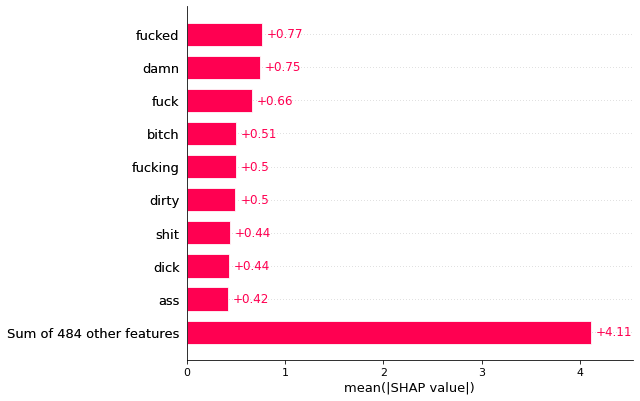

In [ ]:
shap.plots.bar(shap_values[:, :, 1])

In addition to slicing, Explanation objects also support a set of reducing methods. Here we use the .mean(0) to take the average impact of all words towards the "joy" class. Note that here we are also averaging over three examples, to get a better summary you would want to use a larger portion of the dataset.

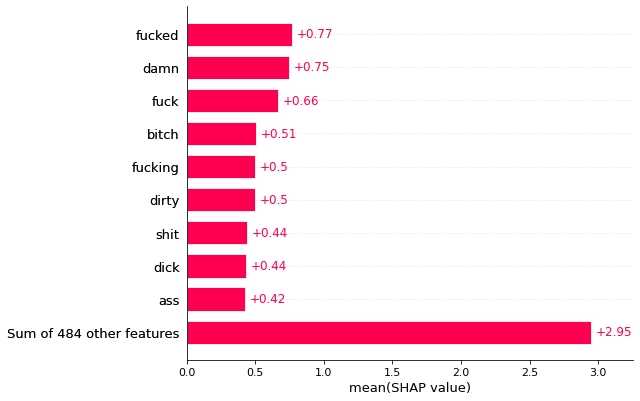

In [ ]:
shap.plots.bar(shap_values[:, :, 1].mean(0), order=shap.Explanation.argsort.flip)

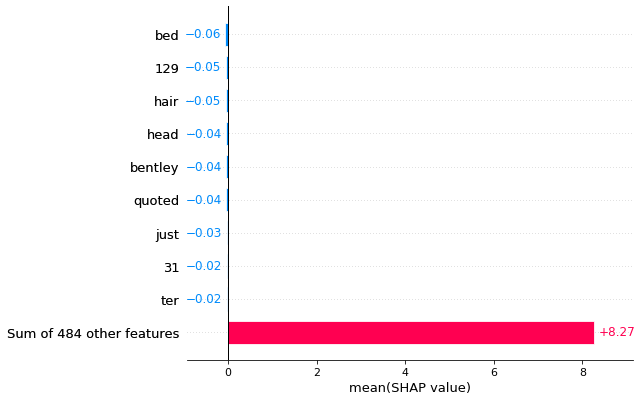

In [ ]:
shap.plots.bar(shap_values[:, :, 1].mean(0), order=shap.Explanation.argsort)

In the examples above we explained the direct output of the pipline object, which are class probabilities. Sometimes it makes more sense to work in a log odds space where it is natural to add and subtract effects (addition and subtraction correspond to the addition or subtraction of bits of evidence information). To work with logits we can use a parameter of the shap.models.TransformersPipeline object:

from https://github.com/slundberg/shap/blob/master/notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.ipynb

In [ ]:
logit_explainer = shap.Explainer(shap.models.TransformersPipeline(pipe, rescale_to_logits=True))

logit_shap_values = logit_explainer(subset)

In [ ]:
'''PIK = "logit_shap_values.dat"
with open('/content/gdrive/My Drive/Colab Notebooks/XKDD/'+PIK, "wb") as f:
  pickle.dump(logit_shap_values, f)'''
PIK = "logit_shap_values.dat"
with open('/content/gdrive/My Drive/Colab Notebooks/XKDD/'+PIK, "rb") as f:
  logit_shap_values = pickle.load(f)

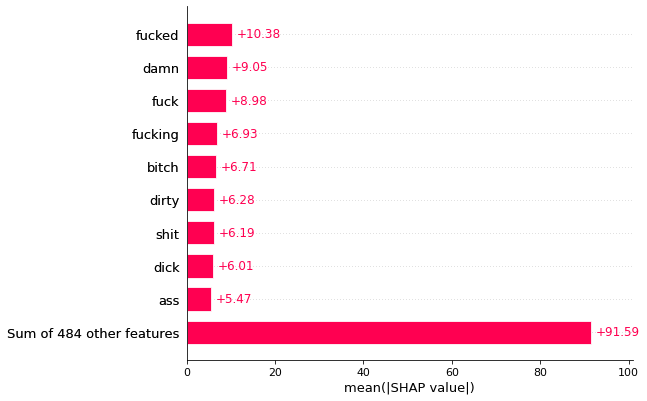

In [ ]:
shap.plots.bar(logit_shap_values[:, :, 1])

#### Local

In the plots below, when you hover your mouse over an output class you get the explanation for that output class. When you click an output class name then that class remains the focus of the explanation visualization until you click another class.

The base value is what the model outputs when the entire input text is masked, while  is the output of the model for the full original input. The SHAP values explain in an addive way how the impact of unmasking each word changes the model output from the base value (where the entire input is masked) to the final prediction value.

Since Explanation objects are sliceable we can slice out just a single output class to visualize the model output towards that class.

Quelli erroneamente considerati come abusivi nel subset: non ci sono! Quelli non abusivi quindi secondo ground truth e classificatore:

In [ ]:
logit_explainer = shap.Explainer(shap.models.TransformersPipeline(pipe, rescale_to_logits=True))

logit_shap_values = logit_explainer(AAE_X_test.text[ids_NA])

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 3/3 [01:17<00:00, 27.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 4it [02:02, 40.96s/it]


In [ ]:
shap.plots.text(logit_shap_values[0, :, 1])

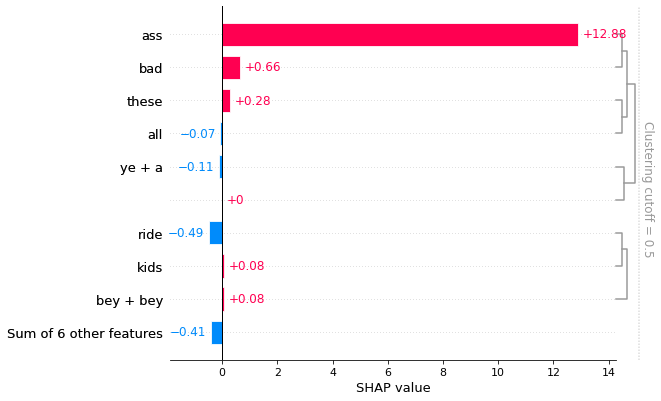

In [ ]:
shap.plots.bar(logit_shap_values[0, :, 1])

In [ ]:
shap.plots.text(logit_shap_values[1, :, 1])

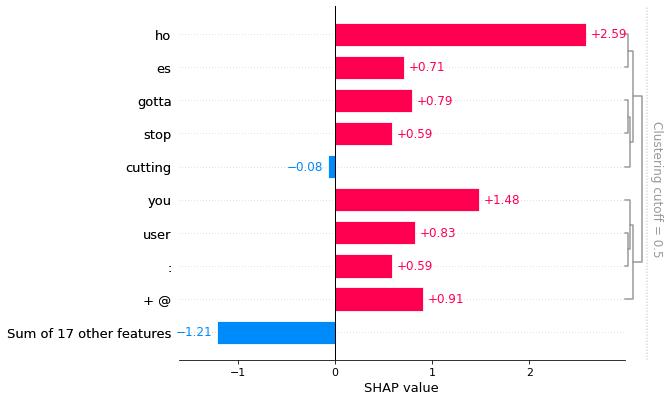

In [ ]:
shap.plots.bar(logit_shap_values[1, :, 1])

In [ ]:
shap.plots.text(logit_shap_values[2, :, 1])

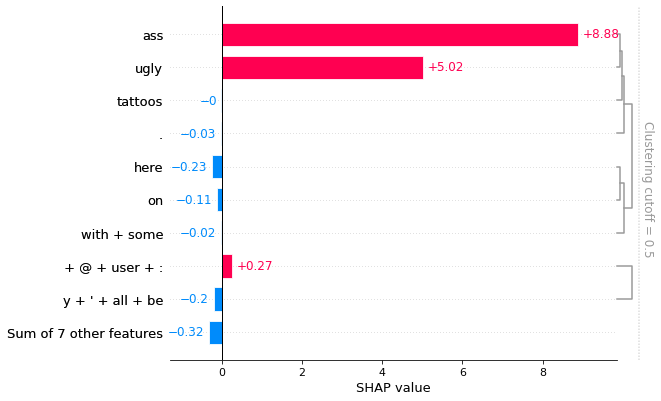

In [ ]:
shap.plots.bar(logit_shap_values[2, :, 1])

Quelli predetti abusivi con le top-words

In [ ]:
logit_shap_values = logit_explainer([A_w_top_w[i] for i in [0,2,4,5,8,9,10,11]])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  12%|█▎        | 1/8 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 3/8 [02:43<02:39, 31.84s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 4/8 [02:55<01:33, 23.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  62%|██████▎   | 5/8 [03:51<01:46, 35.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 6/8 [05:39<02:01, 60.87s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 7/8 [06:21<00:54, 54.49s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 8/8 [06:46<00:00, 45.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 9it [08:00, 60.05s/it]


In [ ]:
i = 0
shap.plots.text(logit_shap_values[i, :, 1])

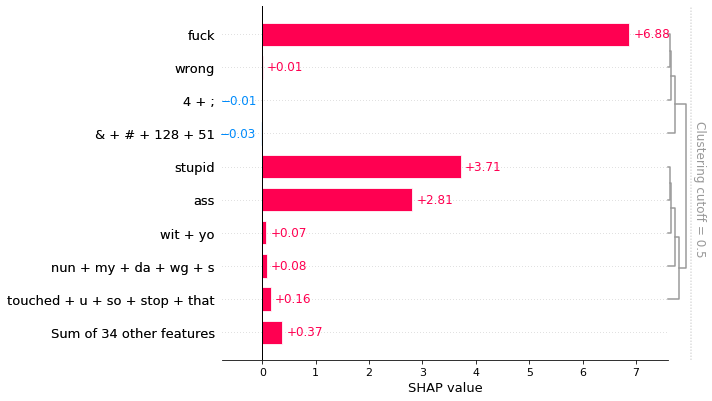

In [ ]:
shap.plots.bar(logit_shap_values[i, :, 1])

In [ ]:
i = 1
shap.plots.text(logit_shap_values[i, :, 1])

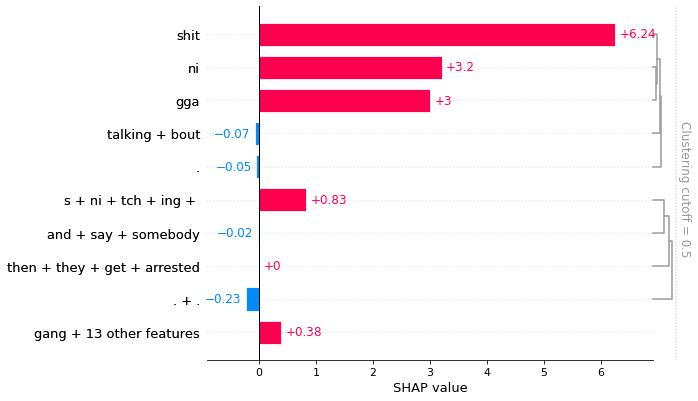

In [ ]:
shap.plots.bar(logit_shap_values[i, :, 1])

In [ ]:
i = 2
shap.plots.text(logit_shap_values[i, :, 1])

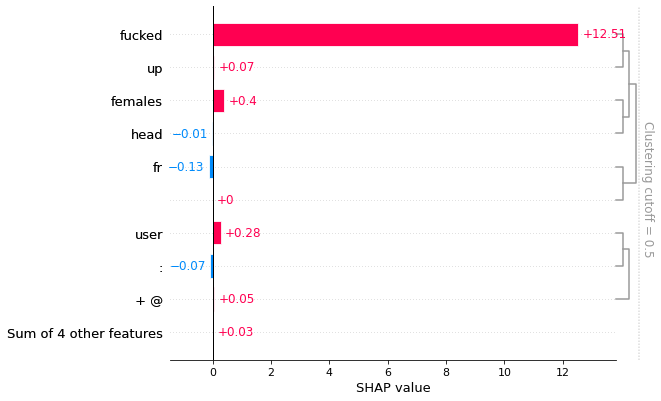

In [ ]:
shap.plots.bar(logit_shap_values[i, :, 1])

In [ ]:
i = 3
shap.plots.text(logit_shap_values[i, :, 1])

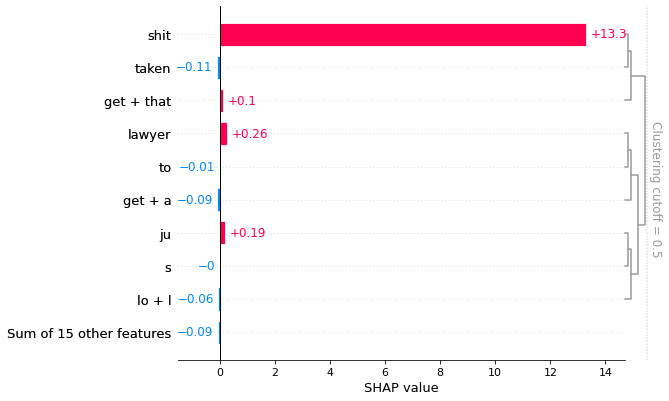

In [ ]:
shap.plots.bar(logit_shap_values[i, :, 1])

In [ ]:
i = 4
shap.plots.text(logit_shap_values[i, :, 1])

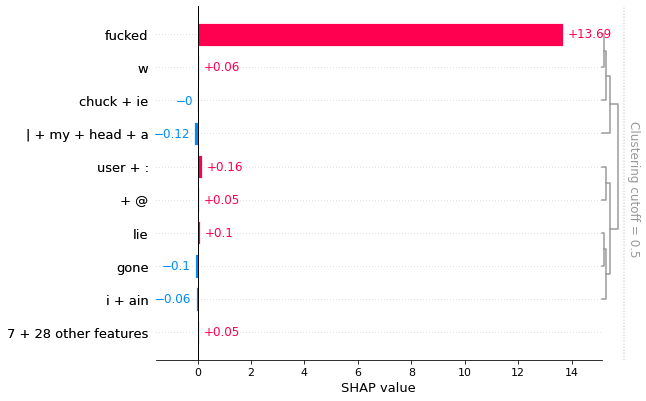

In [ ]:
shap.plots.bar(logit_shap_values[i, :, 1])

In [ ]:
i = 5
shap.plots.text(logit_shap_values[i, :, 1])

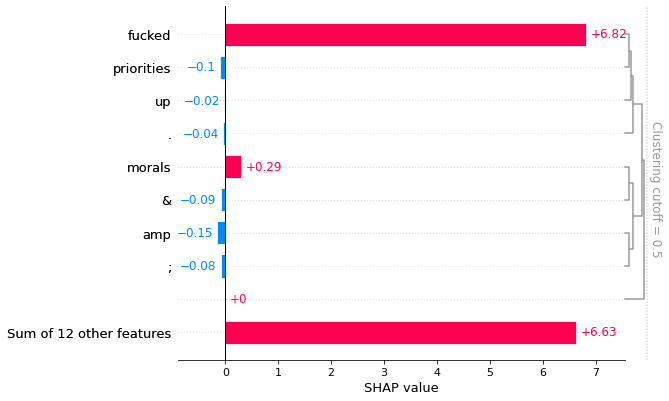

In [ ]:
shap.plots.bar(logit_shap_values[i, :, 1])

In [ ]:
i = 6
shap.plots.text(logit_shap_values[i, :, 1])

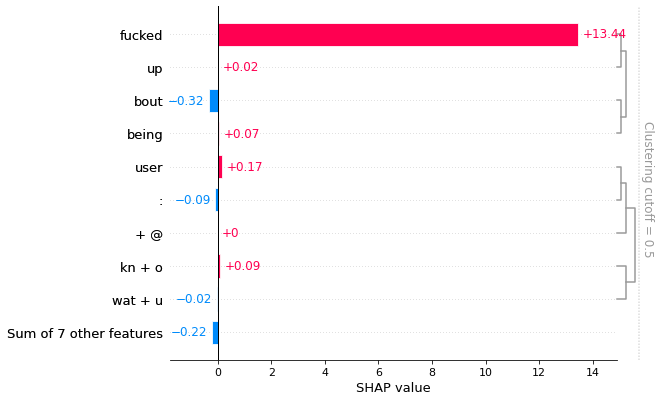

In [ ]:
shap.plots.bar(logit_shap_values[i, :, 1])

In [ ]:
i = 7
shap.plots.text(logit_shap_values[i, :, 1])

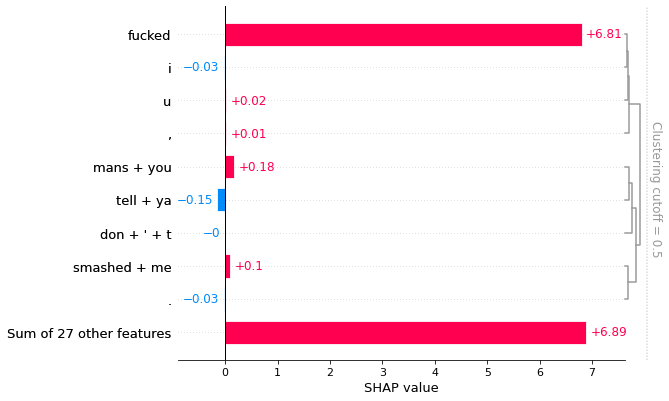

In [ ]:
shap.plots.bar(logit_shap_values[i, :, 1])